# 2b. Supervised Model on Unseen Data

### Goal: Classify real-time tweets from blue-checkmarked Twitter accounts

Like the models trained on historical Tweets, we use list of terms correlated with road closures. The real time tweets are then classified and evaluated using the models trained on the historical tweets. To confrim the effectiveness of the models, we also generate predictions using the models and compare to the keyword classified target variable.

The real time tweets are taken from a curated list of traffic and weather reports from Jacksonville, FL.

- [**Import Libraries**](#Import-Libraries)
- [**EDA and Preprocessing**](#Exploratory-Data-Analysis-and-Preproccessing)
  - [Import Real Time Tweets](#Import-Real-Time-Tweets)
  - [Bar Plot](#Bar-Plot-Function)
  - [Regex Filter](#Regex-Text-Filter)
  - [Keyword Classification](#Keyword-Classification)
  - [Classification Evaluation](#Classification-Evaluation)
- [**Modeling**](#Modeling)
  - [Confusion Matrix Function](#Confusion-Matrix-Function)
  - [Regression Coefficient Plot Function](#Regression-Coefficient-Plot-Function)
  - [ROC AUC Plot Function](#ROC-AUC-Plot-Function)
  - [Logistic Regression with Count Vectorizer](#Logistic-Regression-with-Count-Vectorizer)
  - [TF-IDF Vectorizer and Gradient Boost](#TF-IDF-and-Gradient-Boosting)
- [**Modeling Unseen Data without Keyword Classification**](#Modeling-Unseen-Data-without-Keyword-Classification)
  - [Logistic Regression with Count Vectorizer](#Logistic-Regression-with-Count-Vectorizer)
  - [TF-IDF Vectorizer and Gradient Boost](#TF-IDF-and-Gradient-Boosting)
  - [Evaluation](#Evaluation)

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import pickle

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_colwidth', -1)

/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Exploratory Data Analysis and Preproccessing

#### Import Real Time Tweets

In [2]:
# import tweets
tweets = pd.read_csv("../data/Current_Tweets/RT_tweets_official_08022019.csv")

In [3]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2019-08-02 13:12:24,NaN,[],1157277973734678528,"Updated: Crash in Duval on SR-202 / Butler Blvd west at I-295 E, right lane blocked. Last updated at 09:12:02AM. https://t.co/D0G8dvGzZY",official,fl511_northeast
1,2019-08-02 13:06:27,NaN,"[{'text': 'ANJTraffic', 'indices': [38, 49]}]",1157276473583120384,Good News!! Project wrapped early!!!! #ANJTraffic @ActionNewsJax @WOKVNews https://t.co/NpDbesQ33Z,official,ActionTraffic
2,2019-08-02 13:04:02,NaN,[],1157275867476836357,Roosevelt Boulevard and San Juan Avenue railroad crossing reconstruction is complete and the intersection has reopened.,official,JSOPIO
3,2019-08-02 12:46:32,NaN,[],1157271464728518657,Year to Date in 2019:\n101 Traffic Fatalities in Duval County.\n\n🚗vs🚶🏻‍♂️= 27 (27%)\n🚗vs🚙= 26 (26%)\n🚙= 26 (26%)\n🚗vs🏍=… https://t.co/17i9MYQLYa,official,JSOPIO
4,2019-08-02 11:48:59,NaN,[],1157256980781813760,Jacksonville: There will be lane closure on New Kings Rd northbound from Dunn Ave to Woodley Rd due to...https://t.co/q6rZmrGQeC,official,fl511_northeast


In [4]:
# all tweets taken realtime will be from accounts that primarily report on
# traffic in jacksonville, fl, so state will be marked as Florida
accounts = tweets['username'].unique()
tweets['state'] = 'Florida'

#### Bar Plot Function

In [5]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

#### Regex Text Filter

In [6]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [7]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Keyword Classification

We use the same three lists of words to classify whether Tweets are about road closures.

In [8]:
# establish lists of words to search for in dataframe

# list of words having to do with roads
road_keywords = ['road', 'st', 'rd', 'hwy', 'highway', 'ave', 'avenue',
                 'intersection', 'bridge', 'sr-', 'cr-', 'us-', 'i-', 'blvd']

# list of words associated with road closures
closed_keywords = ['closed', 'remains closed', 'shut down', 'backed up',
                   'no travel', 'delay', 'blocked', 'delays',
                   'disabled', 'traffic', 'fire', 'flood', 'closures', 'closure']

# list of words that would generate false positives
to_drop = ["open", "opened", "lifted", "reopened", "clear", "cleared"]

In [9]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
# modified code from arielle miro
def tweet_filter (df, col, keywords, roads, dropwords):
    
    # create a new column in the given dataframe
    # assign a value of 1 if any word in the text is in the keyword and road lists
    # assign a value of 0 if any word in the test is in the drop words list
    df['road_closure'] = df[col].map(lambda x: 1 if ((any(word in x for word in roads)) 
                                                     & (any(word in x for word in keywords)) 
                                                     & (not any(word in x for word in dropwords))) 
                                     else 0)   
    return df['road_closure']

In [10]:
# backup original tweet to new dataframe
tweets['tweet'] = tweets['text']

# make tweet text lowercase
tweets['text'] = tweets['text'].str.lower()

# run function on full dataframe
tweets['road_closure'] = tweet_filter(tweets, 'text', closed_keywords, road_keywords, to_drop)

In [11]:
# check shape and classification values of tweets
print(tweets.shape)
tweets['road_closure'].value_counts()

(200, 10)


1    129
0    71 
Name: road_closure, dtype: int64

## Classification Evaluation

In [12]:
# create a dataframe of only closures
closed = tweets[tweets['road_closure'] == 1]

In [13]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_northeast    121
ActionTraffic      4  
JFRDJAX            3  
JSOPIO             1  
Name: username, dtype: int64

In [14]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(129, 270)


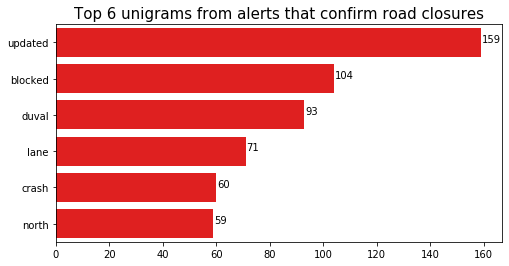

In [15]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [16]:
# Remove all road closure tweets from full dataframe
tweets_open = tweets[tweets['road_closure'] == 0]

# Shape
tweets_open.shape

(71, 10)

In [17]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(71, 329)


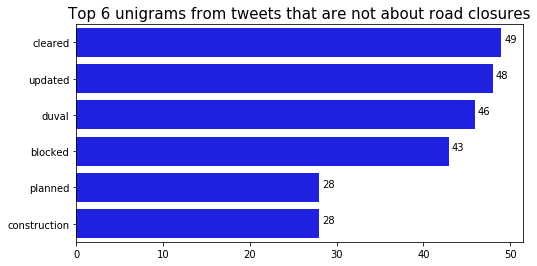

In [18]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [19]:
# copy dataframe
tweets_training = tweets
tweets_training.shape

(200, 10)

In [20]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2019-08-02 13:12:24,NaN,[],1157277973734678528,updated crash in duval on sr-202 butler blvd west at i-295 e right lane blocked last updated at 09 12 02am,official,fl511_northeast,Florida,Updated Crash in Duval on SR-202 Butler Blvd west at I-295 E right lane blocked Last updated at 09 12 02AM,1
1,2019-08-02 13:06:27,NaN,"[{'text': 'ANJTraffic', 'indices': [38, 49]}]",1157276473583120384,good news project wrapped early #anjtraffic actionnewsjax wokvnews,official,ActionTraffic,Florida,Good News Project wrapped early #ANJTraffic ActionNewsJax WOKVNews,0
2,2019-08-02 13:04:02,NaN,[],1157275867476836357,roosevelt boulevard and san juan avenue railroad crossing reconstruction is complete and the intersection has reopened,official,JSOPIO,Florida,Roosevelt Boulevard and San Juan Avenue railroad crossing reconstruction is complete and the intersection has reopened,0
3,2019-08-02 12:46:32,NaN,[],1157271464728518657,year to date in 2019 \n101 traffic fatalities in duval county \n\n🚗vs🚶🏻‍♂️= 27 27 \n🚗vs🚙= 26 26 \n🚙= 26 26 \n🚗vs🏍=…,official,JSOPIO,Florida,Year to Date in 2019 \n101 Traffic Fatalities in Duval County \n\n🚗vs🚶🏻‍♂️= 27 27 \n🚗vs🚙= 26 26 \n🚙= 26 26 \n🚗vs🏍=…,0
4,2019-08-02 11:48:59,NaN,[],1157256980781813760,jacksonville there will be lane closure on new kings rd northbound from dunn ave to woodley rd due to,official,fl511_northeast,Florida,Jacksonville There will be lane closure on New Kings Rd northbound from Dunn Ave to Woodley Rd due to,1


# Modeling

We run the same two models trained on the historical Tweets on the new, unseen, real time Tweets. We evaluate each model using a classification matrix and an ROC AUC curve.

In [21]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.645
0    0.355
Name: road_closure, dtype: float64

In [22]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [23]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .3,
                                                    random_state=42,
                                                    stratify=y)

#### Confusion Matrix Function

In [24]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [25]:
# function to print classification metrics
def classif_metrics(y_true, y_predicted):
    
    # generate confusion matrix
    cm1 = confusion_matrix(y_true, y_predicted)
    total1=sum(sum(cm1))
    
    # from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    
    # from confusion matrix calculate sensitivity
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    
    # from confusion matrix calculate specificity
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    
    return cm1

#### Regression Coefficient Plot Function

In [26]:
# function to plot regression coeficients for NLP models
# modified code from jasmine vasandani
def regression_coef_plot(pipe, e_name, v_name):
    # Create list of logistic regression coefficients 
    lr_coef = np.array(pipe.best_estimator_.named_steps[e_name].coef_).tolist()
    lr_coef = lr_coef[0]

    # create dataframe from lasso coef
    lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
    pipe.best_estimator_.named_steps[v_name].get_feature_names(), columns = ["lr_coef"])

    # sort the values from high to low
    lr_coef = lr_coef.sort_values(by = 'lr_coef', 
    ascending = False)

    # Create top and bottom 10 
    df_head = lr_coef.head(10)
    df_tail = lr_coef.tail(10)

    # merge back together
    df_merged = pd.concat([df_head, df_tail], axis=0)

    # plot the sorted dataframe
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    fig.suptitle('Coefficients', size=14)
    ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
    data=df_merged, palette= 'cubehelix')
    ax.set(xlabel='Regression Coefficients')
    plt.tight_layout(pad=3, w_pad=0, h_pad=0);

#### ROC AUC Plot Function

In [27]:
# helper functions for ROC AUC curve
# modified code from Arielle Miro

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [28]:
# function to plot ROC AUC curve
# modified code from Tim Book
def roc_auc(X, y, estimator):
    
    # Create figure.
    plt.figure(figsize = (12,10))
    
    # calculate predicted probabilities
    pred_proba = [i[1] for i in estimator.predict_proba(X)]

    pred_df = pd.DataFrame({'true_values': y,
                            'pred_probs':pred_proba})

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {roc_auc_score(y, estimator.predict(X))}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

## Logistic Regression with Count Vectorizer

As with the historic tweets, this model scored very well due to keyword classification. The model did not score as highly as on the traning data, but was still very accurate

The model fit on training and testing split had an *r2* score of about 96.19% and 99.29%, ROC AUC of 93.77%, and minimal false positives.

In [29]:
# run pickled logisitic regression model

# load the model from disk
filename = '../data/Models/lr_cvec_07302019.sav'
lr = joblib.load(filename)

# Create the predictions for Y training data
y_pred = lr.predict(X_test)

print(f'Train Score: {lr.score(X_train, y_train)}')
print(f'Test Score: {lr.score(X_test, y_test)}')

Train Score: 0.9805555555555555
Test Score: 0.9975579975579976


Confusion matrix, without normalization
[[20  1]
 [ 1 38]]


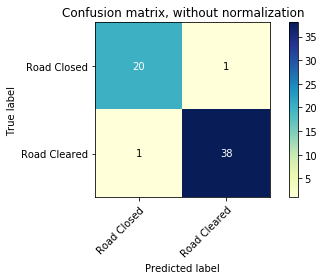

In [30]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# generate predictions
y_pred = lr.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

In [31]:
# print classif metrics
classif_metrics(y_test, y_pred)

Accuracy :  0.9666666666666667
Sensitivity :  0.9523809523809523
Specificity :  0.9743589743589743


array([[20,  1],
       [ 1, 38]])

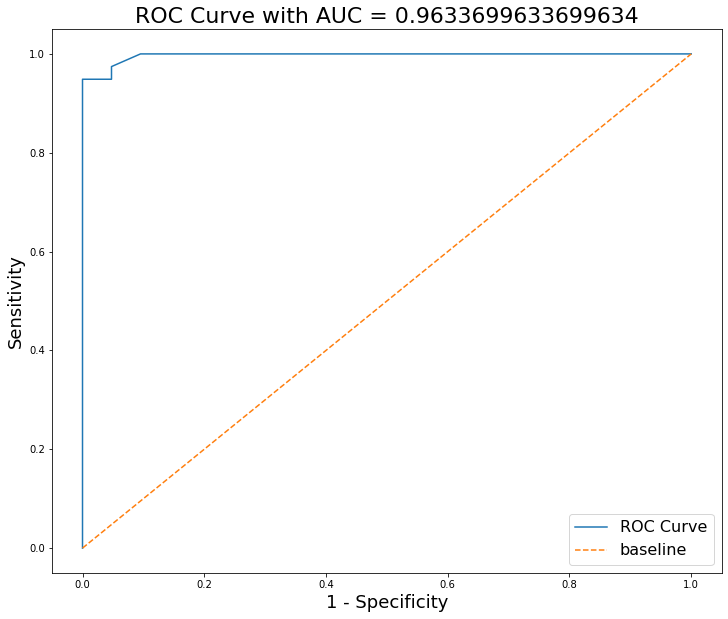

In [32]:
# run AUC ROC curve function
roc_auc(X_test, y_test, lr)

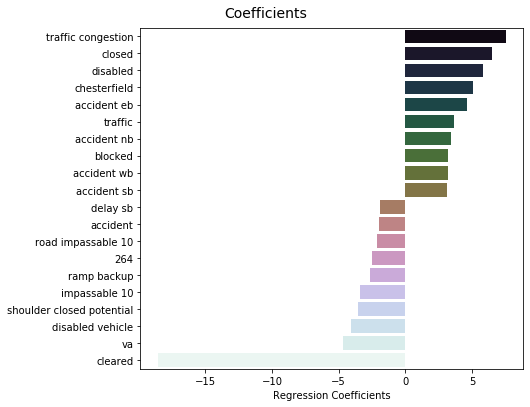

In [33]:
# run regression coefficient plot
# note: this data comes from being fit from the training data
# does not reflect the unseen data
regression_coef_plot(lr, 'lr', 'vec')

## TF-IDF and Gradient Boosting

Like with the Logistic Regression model, the TF-IDF Gradient Boosted classifier was not able to match the scores from the historical tweets, but still performed well.

The model fit on training and testing data had an *r2* score of about 96.8% and 98.82%, ROC AUC of 97.29%, and minimal false positives.

In [34]:
# run gradient pickled boosting classifier
# load the model from disk

filename = '../data/Models/gb_tvec_07302019.sav'
gb = joblib.load(filename)

# Create the predictions for Y training data
y_pred = gb.predict(X_test)

print(f'Train Score: {gb.score(X_train, y_train)}')
print(f'Test Score: {gb.score(X_test, y_test)}')

Train Score: 0.979111111111111
Test Score: 0.9884004884004884


Confusion matrix, without normalization
[[20  1]
 [ 1 38]]


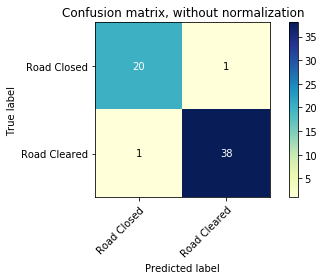

In [35]:
# generate predictions
y_pred = gb.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

In [36]:
# print classif metrics
classif_metrics(y_test, y_pred)

Accuracy :  0.9666666666666667
Sensitivity :  0.9523809523809523
Specificity :  0.9743589743589743


array([[20,  1],
       [ 1, 38]])

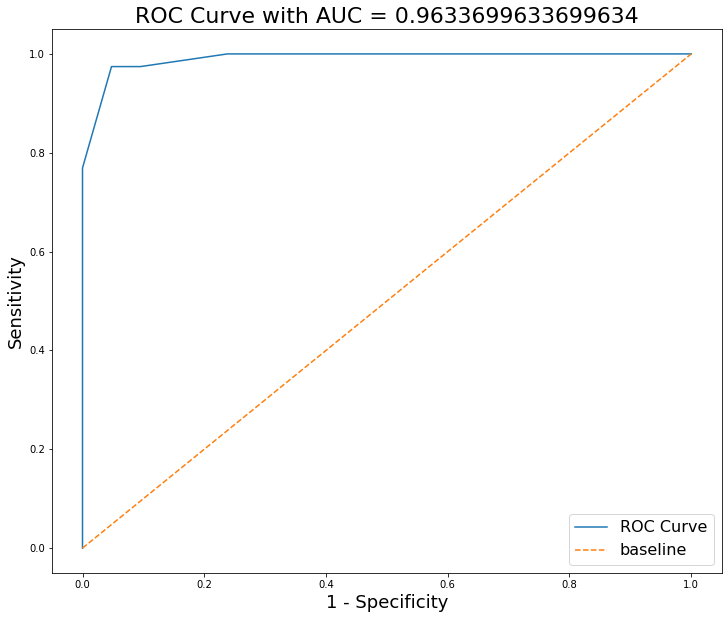

In [37]:
# run AUC ROC curve function
roc_auc(X_test, y_test, gb)

# Modeling Unseen Data without Keyword Classification

This was the true test for the efficacy of our models. We evaluated the models trained on the keyword classified historical tweets without a target `y` variable for scoring. This was then compared to the keyword classified models with using the generated classification matrices and ROC AUC.

The Gradient Boosted model only misclassified 7 tweets, while the Logistic Regression model misclassified 6. We then were able to look at the misclassified Tweets for tuning purposes.

Due to minimal false positives, this method could be used with streaming real time tweets for classification.

In [38]:
# define our variables
diff_df = tweets_training[['text', 'username', 'road_closure']]
diff_df['lr_pred'] = lr.predict(tweets['text'])
diff_df['gb_pred'] = gb.predict(tweets['text'])

/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## TF-IDF and Gradient Boosting

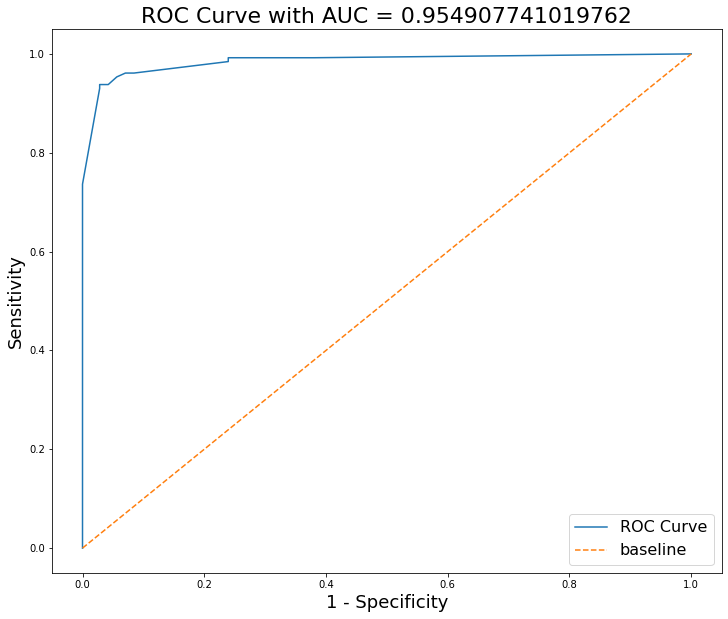

In [39]:
# ROC AUC for gradient boosted model
roc_auc(X, diff_df['road_closure'], gb)

Confusion matrix, without normalization
[[ 69   8]
 [  2 121]]


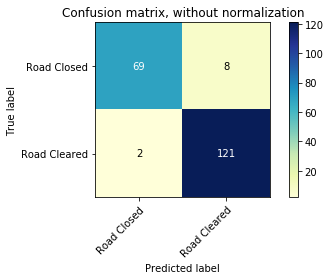

In [40]:
# Plot non-normalized confusion matrix for logistic regression model
plot_confusion_matrix(diff_df['gb_pred'], diff_df['road_closure'], classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')

## Logistic Regression with Count Vectorizer

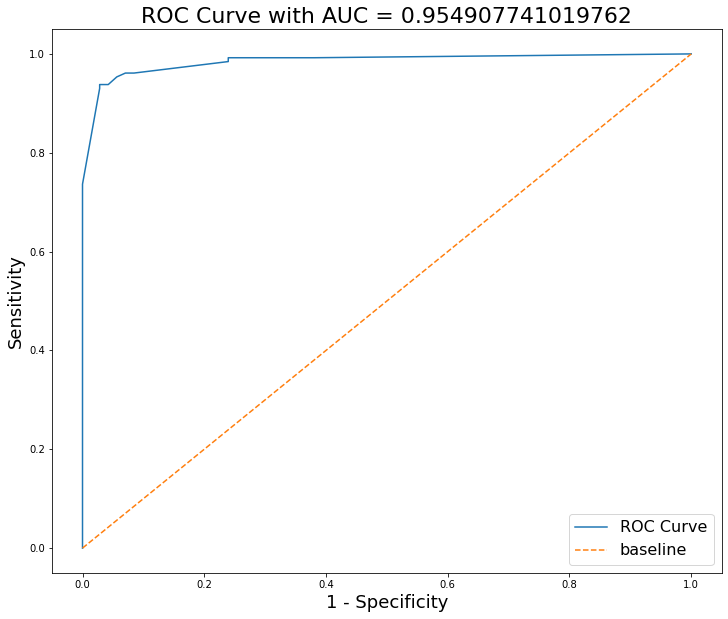

In [41]:
# ROC AUC for logistic regression model
roc_auc(X, diff_df['road_closure'], gb)

Confusion matrix, without normalization
[[ 69   9]
 [  2 120]]


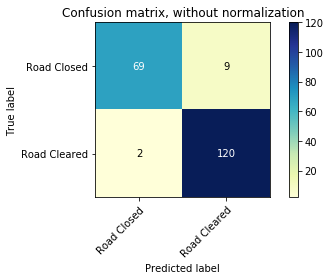

In [42]:
# Plot non-normalized confusion matrix for gradient boosted model
plot_confusion_matrix(diff_df['lr_pred'], diff_df['road_closure'], classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')

## Evaluation

Following the models' predictions, we observed which Tweets were misclassified.

#### False Positives

In [43]:
# looking at the Gradient Boost predictions, look at the tweets that were a false positive
diff_df[(diff_df['road_closure'] == 1) & (diff_df['gb_pred'] == 0)]

,text,username,road_closure,lr_pred,gb_pred
4,jacksonville there will be lane closure on new kings rd northbound from dunn ave to woodley rd due to,fl511_northeast,1,1,0
10,635a- big 3 travel times no problems on the early commute #anjtraffic actionnewsjax wokvnews,ActionTraffic,1,0,0
42,satsuma on us-17 from horse landing road to san mateo drive there will be lane closures due to construction use,fl511_northeast,1,0,0
97,jacksonville due to construction there will be lane closures on new kings rd from woodley rd to dunn avenue and,fl511_northeast,1,0,0
115,750am- big 3 travel times delays continue on i 10 #anjtraffic actionnewsjax wokvnews,ActionTraffic,1,0,0
121,645am- crash on the ramp to chaffee road from i 10 wb #anjtraffic actionnewsjax,ActionTraffic,1,0,0
125,crews are wrapping up a mobile home structure fire in the 7500 block of taurus cir east red cross has been reque…,JFRDJAX,1,0,0
168,jfrdjax actionnewsjax cityofjax docmoreland1 lennycurry fhpjacksonville farmsharefl 😂 it’s ok fireman alwa…,JSOPIO,1,0,0


#### False Negatives

In [44]:
# looking at the Gradient Boost predictions, look at the tweets that were a false negative
diff_df[(diff_df['road_closure'] == 0) & (diff_df['gb_pred'] == 1)]

,text,username,road_closure,lr_pred,gb_pred
3,year to date in 2019 \n101 traffic fatalities in duval county \n\n🚗vs🚶🏻‍♂️= 27 27 \n🚗vs🚙= 26 26 \n🚙= 26 26 \n🚗vs🏍=…,JSOPIO,0,1,1
110,9am- slow ride on 95 nb at philips right lane blocked due to a crash expect delays #anjtraffic actionnewsjax…,ActionTraffic,0,1,1


## Export Dataframe

In [45]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
0,2019-08-02 13:12:24,NaN,[],1157277973734678528,updated crash in duval on sr-202 butler blvd west at i-295 e right lane blocked last updated at 09 12 02am,official,fl511_northeast,Florida,Updated Crash in Duval on SR-202 Butler Blvd west at I-295 E right lane blocked Last updated at 09 12 02AM,1
1,2019-08-02 13:06:27,NaN,"[{'text': 'ANJTraffic', 'indices': [38, 49]}]",1157276473583120384,good news project wrapped early #anjtraffic actionnewsjax wokvnews,official,ActionTraffic,Florida,Good News Project wrapped early #ANJTraffic ActionNewsJax WOKVNews,0
2,2019-08-02 13:04:02,NaN,[],1157275867476836357,roosevelt boulevard and san juan avenue railroad crossing reconstruction is complete and the intersection has reopened,official,JSOPIO,Florida,Roosevelt Boulevard and San Juan Avenue railroad crossing reconstruction is complete and the intersection has reopened,0
3,2019-08-02 12:46:32,NaN,[],1157271464728518657,year to date in 2019 \n101 traffic fatalities in duval county \n\n🚗vs🚶🏻‍♂️= 27 27 \n🚗vs🚙= 26 26 \n🚙= 26 26 \n🚗vs🏍=…,official,JSOPIO,Florida,Year to Date in 2019 \n101 Traffic Fatalities in Duval County \n\n🚗vs🚶🏻‍♂️= 27 27 \n🚗vs🚙= 26 26 \n🚙= 26 26 \n🚗vs🏍=…,0
4,2019-08-02 11:48:59,NaN,[],1157256980781813760,jacksonville there will be lane closure on new kings rd northbound from dunn ave to woodley rd due to,official,fl511_northeast,Florida,Jacksonville There will be lane closure on New Kings Rd northbound from Dunn Ave to Woodley Rd due to,1


In [46]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_RT_official_08022019.csv', index = False)